<a href="https://colab.research.google.com/github/khairul746/IDCamp-ML-Engineer-2024-Projects/blob/main/Klasifikasi-Gambar/Klasifikasi_Gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Images Classification
Khairullah Ilyas \
Dicoding IDCamp 2024 : Intermediate Level Submission

## 1. Import Library

In [1]:
import kagglehub
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import zipfile
import os
import shutil
import os

from sklearn.model_selection import train_test_split

## 2. Load Dataset

In [2]:
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
# Download dataset
!kaggle datasets download --force yessicatuteja/skycity-the-city-landscape-dataset

Dataset URL: https://www.kaggle.com/datasets/yessicatuteja/skycity-the-city-landscape-dataset
License(s): CC0-1.0
 98% 115M/117M [00:06<00:00, 19.3MB/s]
100% 117M/117M [00:06<00:00, 17.9MB/s]


In [4]:
# Ekstrak dataset
zip_path = 'skycity-the-city-landscape-dataset.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

In [5]:
# Path to the train directory
data_dir = "/content/Cityscape Dataset"

### 2.1. Images Count

In [7]:
def count_images(data_dir):
    class_counts = {}
    total_images = 0
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):  # Ensure it's a directory (a class)
            image_count = len(os.listdir(class_path))
            class_counts[class_name] = image_count
            total_images += image_count
    return class_counts, total_images


class_counts, total_images = count_images(data_dir)

print("Jumlah gambar per kelas:")
for class_name, count in class_counts.items():
    print(f"- {class_name}: {count}")

print(f"\nTotal jumlah gambar: {total_images}")


Jumlah gambar per kelas:
- Parking: 800
- Commercial: 800
- Intersection: 800
- Residential: 800
- Playground: 800
- Stadium: 800
- Landmark: 800
- Bridge: 800
- Park: 800
- Industrial: 800

Total jumlah gambar: 8000


### 2.2. Image Resolutions Checking

In [8]:
# Dictionary to store image resolutions
image_resolutions = {}

# Counter to limit the number of images processed
image_count = 0
max_images = 10

# Iterate through each subfolder and image file
for subdir, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith(('jpg', 'jpeg', 'png')):
            file_path = os.path.join(subdir, file)
            with Image.open(file_path) as img:
                image_resolutions[file_path] = img.size
                image_count += 1
                if image_count >= max_images:
                    break

# Print the resolutions
for path, resolution in image_resolutions.items():
    print(f'{path}: {resolution}')

/content/Cityscape Dataset/Parking/791.jpg: (256, 256)
/content/Cityscape Dataset/Parking/167.jpg: (256, 256)
/content/Cityscape Dataset/Parking/181.jpg: (256, 256)
/content/Cityscape Dataset/Parking/251.jpg: (256, 256)
/content/Cityscape Dataset/Parking/677.jpg: (256, 256)
/content/Cityscape Dataset/Parking/477.jpg: (256, 256)
/content/Cityscape Dataset/Parking/372.jpg: (256, 256)
/content/Cityscape Dataset/Parking/551.jpg: (256, 256)
/content/Cityscape Dataset/Parking/091.jpg: (256, 256)
/content/Cityscape Dataset/Parking/213.jpg: (256, 256)
/content/Cityscape Dataset/Commercial/791.jpg: (256, 256)
/content/Cityscape Dataset/Intersection/791.jpg: (256, 256)
/content/Cityscape Dataset/Residential/791.jpg: (256, 256)
/content/Cityscape Dataset/Playground/791.jpg: (256, 256)
/content/Cityscape Dataset/Stadium/791.jpg: (256, 256)
/content/Cityscape Dataset/Landmark/791.jpg: (256, 256)
/content/Cityscape Dataset/Bridge/791.jpg: (256, 256)
/content/Cityscape Dataset/Park/791.jpg: (256, 256

## 3. Augmentasi Gambar dan Pemisahan Data

### 3.1. Train test split

In [9]:
# Path ke dataset
train_dir = "data/train"
test_dir = "data/test"

# Buat direktori baru untuk menyimpan data yang sudah dibagi
for folder in [train_dir, test_dir]:
    for class_name in os.listdir(data_dir):
        os.makedirs(os.path.join(folder, class_name), exist_ok=True)

In [10]:
# Ambil daftar gambar untuk setiap kelas
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    images = os.listdir(class_path)

    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)  # 80% Train, 20% Test
    # Copy gambar ke direktori baru
    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))


### 3.2. Augmentasi Gambar

In [11]:
# Create an ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Create a generator for the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Create a generator for the validation data
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 5120 images belonging to 10 classes.
Found 1280 images belonging to 10 classes.


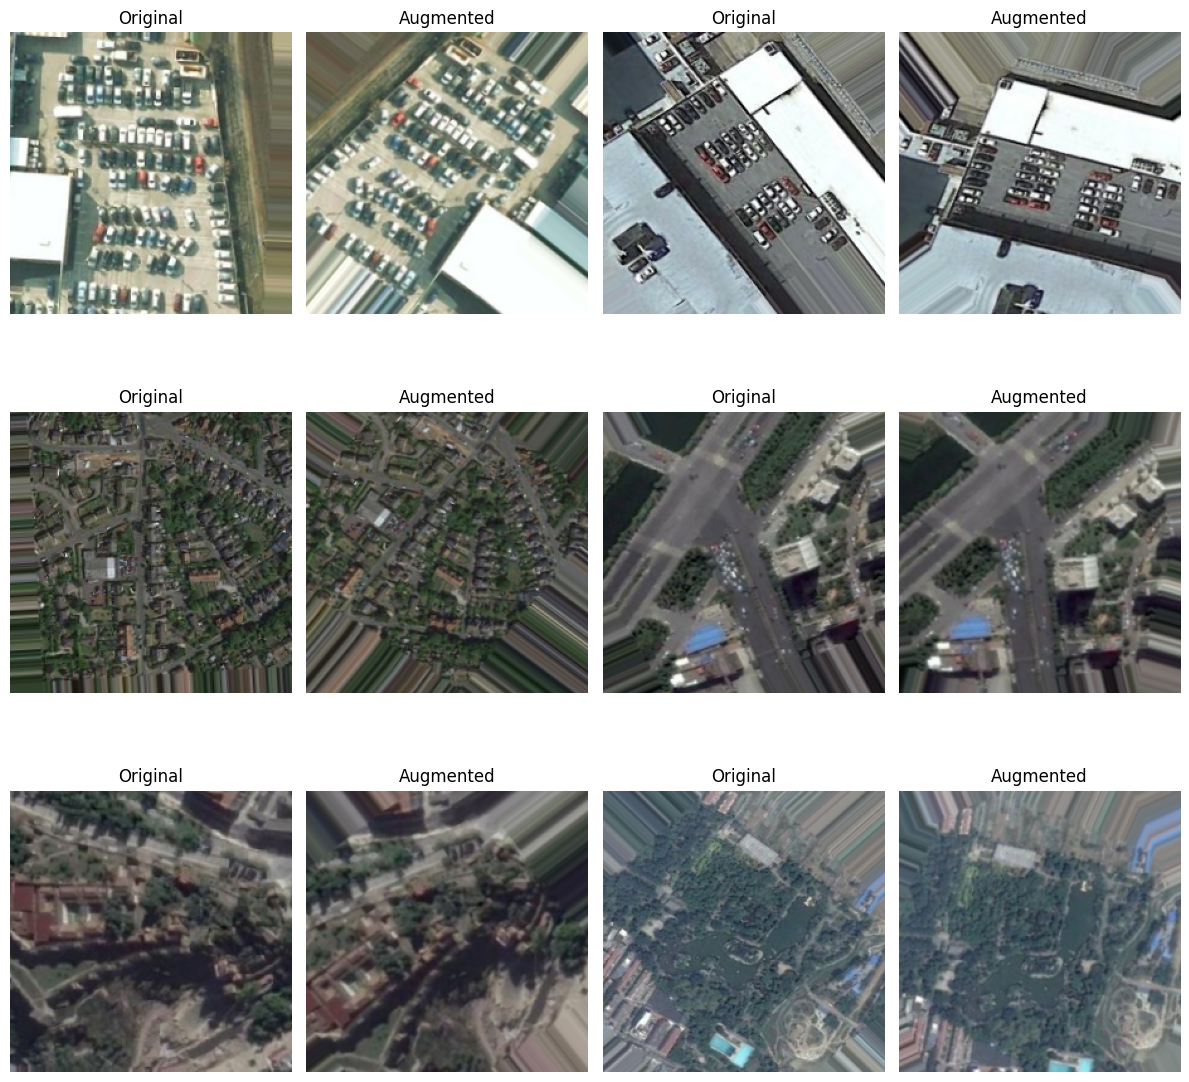

In [12]:
# Ambil batch gambar dari train_generator
images, labels = next(train_generator)

# Tampilkan beberapa gambar asli dan hasil augmentasi
plt.figure(figsize=(12, 12))
for i in range(6):
    plt.subplot(3, 4, 2*i+1)
    plt.imshow(images[i])
    plt.title('Original')
    plt.axis('off')

    # Augmentasi gambar
    augmented_image = train_datagen.random_transform(images[i])
    plt.subplot(3, 4, 2*i+2)
    plt.imshow(augmented_image)
    plt.title('Augmented')
    plt.axis('off')

plt.tight_layout()
plt.show()

## 4. Model Development

In [ ]:
tf.keras.backend.clear_session

<function keras.src.backend.common.global_state.clear_session(free_memory=True)>

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from keras.callbacks import Callback

In [14]:
class StopTrainingCallback(Callback):
    def __init__(self, patience=3):
        super(StopTrainingCallback, self).__init__()
        self.patience = patience
        self.best_val_loss = float('inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs={}):
        if logs.get("accuracy") >= 0.95:
            print("\n Akurasi 95% tercapai. Proses train dihentikan...\n")
            self.model.stop_training = True
            return

        current_val_loss = logs.get("val_loss")
        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\n Tidak ada penurunan nilai loss validasi setelah {self.patience} epochs. Proses train dihentikan...\n")
                self.model.stop_training = True

In [1]:
class PlotPerIteration(tf.keras.callbacks.Callback):
    def __init__(self, interval=100):
        self.interval = interval
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []
        self.iterations = 0
        self.epochs = 0

    def on_batch_end(self, batch, logs=None):
        self.iterations += 1
        if self.iterations % self.interval == 0:
            loss = logs.get('loss')
            accuracy = logs.get('accuracy')
            if loss is not None:
                self.losses.append(loss)
            if accuracy is not None:
                self.accuracies.append(accuracy)

    def on_epoch_end(self, epoch, logs=None):
        self.epochs += 1
        val_loss = logs.get('val_loss')
        val_accuracy = logs.get('val_accuracy')
        if val_loss is not None:
            self.val_losses.append(val_loss)
        if val_accuracy is not None:
            self.val_accuracies.append(val_accuracy)

    def plot_metrics(self):
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(range(0, len(self.accuracies)*self.interval, self.interval), self.accuracies, label='Train')
        plt.plot(
            np.linspace(
                len(self.accuracies) * self.interval / len(self.val_accuracies),
                len(self.accuracies) * self.interval,
                int(len(self.val_accuracies))
                ),
            self.val_accuracies, label='Validation')
        plt.title('Model Accuracy (per iteration)')
        plt.ylabel('Accuracy')
        plt.xlabel('Iteration')
        locator = plt.AutoLocator(n=10)
        formatter = plt.FormatStrFormatter('%d')
        plt.gca().xaxis.set_major_locator(locator)
        plt.gca().xaxis.set_major_formatter(formatter)
        plt.grid()
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.subplot(1, 2, 2)
        plt.plot(range(0, len(self.losses)*self.interval, self.interval), self.losses, label='Train')
        plt.plot(
            np.linspace(
                len(self.losses) * self.interval / len(self.val_losses),
                len(self.losses) * self.interval,
                int(len(self.val_losses))
                ),
            self.val_losses, label='Validation')
        plt.title('Model Loss (per iteration)')
        plt.ylabel('Loss')
        plt.xlabel('Iteration')
        locator = plt.AutoLocator(n=10)
        formatter = plt.FormatStrFormatter('%d')
        plt.gca().xaxis.set_major_locator(locator)
        plt.gca().xaxis.set_major_formatter(formatter)
        plt.grid()
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.tight_layout()
        plt.show()

plot_callback = PlotPerIteration(interval=10)

NameError: name 'tf' is not defined

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

In [16]:
# Load pre-trained ResNet50 without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False)

# Add new classification layers
x = base_model.output
x = Conv2D(128, (4, 4), activation='relu')(x) # Conv2D layer
x = MaxPooling2D((2, 2))(x) # MaxPooling2D layer
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

# Create the fine-tuned model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [17]:
# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, validation_data=validation_generator, epochs=20, callbacks = [StopTrainingCallback(patience=5),plot_callback])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 98s 515ms/step - accuracy: 0.1771 - loss: 2.7380 - val_accuracy: 0.2430 - val_loss: 1.9902
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 78s 490ms/step - accuracy: 0.2825 - loss: 1.9277 - val_accuracy: 0.2812 - val_loss: 1.8492
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 78s 485ms/step - accuracy: 0.3272 - loss: 1.8251 - val_accuracy: 0.3336 - val_loss: 1.7572
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 78s 486ms/step - accuracy: 0.3692 - loss: 1.7333 - val_accuracy: 0.2961 - val_loss: 1.8487
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 77s 483ms/step - accuracy: 0.3514 - loss: 1.7513 - val_accuracy: 0.3438 - val_loss: 1.7733
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 512ms/step - accuracy: 0.3991 - loss: 1.6796 - val_accuracy: 0.3555 - val_loss: 1.7084
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 77s 481ms/step - accuracy: 0.3976 - loss: 1.6580 - val_accuracy: 0.3922 - val_loss: 1.6399
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 78s 485ms/step - accuracy: 0.4280 - loss: 1

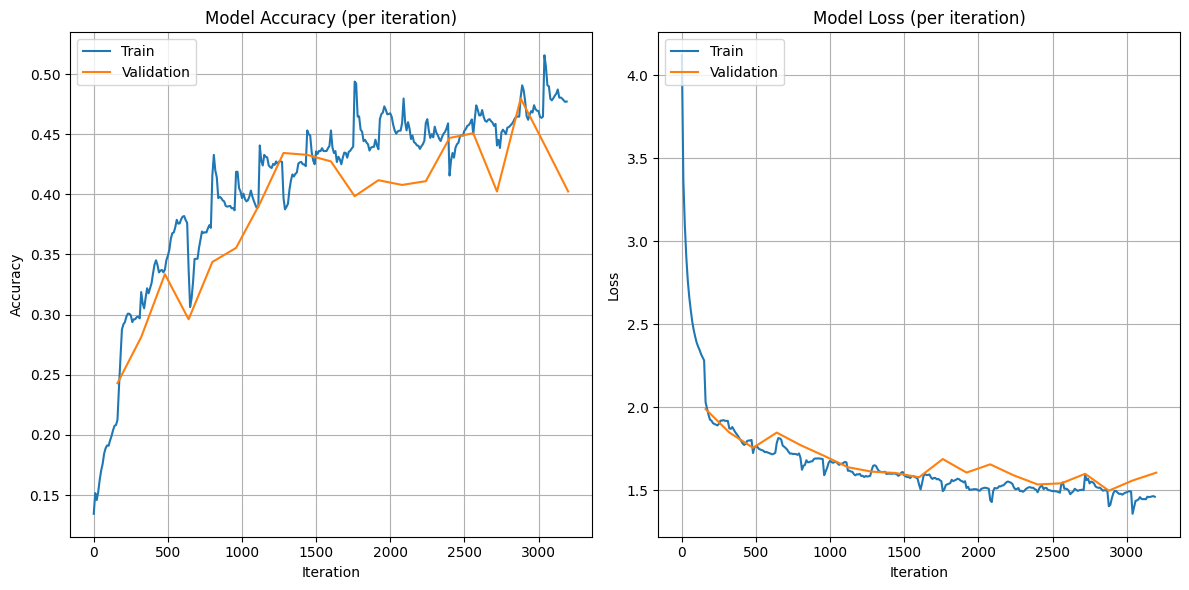

In [18]:
plot_callback.plot_metrics()

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 29.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [ ]:
import tensorflowjs as tfjs
import tensorflow as tf

# Save the model in TensorFlow.js format
tfjs.converters.save_keras_model(model, 'tfjs_model')

# Convert and save the model in TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


# Save the model for TensorFlow Serving
# Create a directory for the saved model
import os
model_version = 1
export_path = os.path.join('serving_model', str(model_version))
print('export_path = {}\n'.format(export_path))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

tf.saved_model.save(model, export_path)
print('\nSaved model:')
!ls -l {export_path}


failed to lookup keras version from the file,
    this is likely a weight only file
Saved artifact at '/tmp/tmpge7qoakf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139191219732304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191219731344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191219727120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191188192336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191188193104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191188488848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191188490000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191188489424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191188489040: TensorSpec(shape=(), dtype=tf.resource, name=None)

In [ ]:
# prompt: gunakan salah satu model yang disimpan untuk menguji suatu gambar dari luar

import tensorflow as tf
import numpy as np
from PIL import Image

# Load the saved model
model = tf.keras.models.load_model('serving_model/1') # Replace with the actual path

# Preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Path to the image you want to test
image_path = '/content/image_to_test.jpg' # Replace with the actual path

# Preprocess the image
preprocessed_image = preprocess_image(image_path)


# Make predictions
predictions = model.predict(preprocessed_image)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Print the prediction
print(f"Predicted class: {predicted_class}")
# You might need to map the predicted_class index to the actual class label.
# This depends on how your labels were encoded when training the model.
# For example:
# class_labels = ['class_1', 'class_2', 'class_3']
# print(f"Predicted class: {class_labels[predicted_class]}")


ValueError: File format not supported: filepath=serving_model/1. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(serving_model/1, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the saved model using tf.saved_model.load
model = tf.saved_model.load('serving_model/1')

# Preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Path to the image you want to test
image_path = '/content/image_to_test.jpg' # Replace with the actual path

# Preprocess the image
preprocessed_image = preprocess_image(image_path)


# Make predictions
predictions = model.predict(preprocessed_image)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Print the prediction
print(f"Predicted class: {predicted_class}")
# You might need to map the predicted_class index to the actual class label.
# This depends on how your labels were encoded when training the model.
# For example:
# class_labels = ['class_1', 'class_2', 'class_3']
# print(f"Predicted class: {class_labels[predicted_class]}")
